# Load price data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

path = "C:/Users/itataurov/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df.rename(columns={'datetime':'timestamp'}, inplace=True)
df = df.sort_values(by=['timestamp'])

# Universe growth

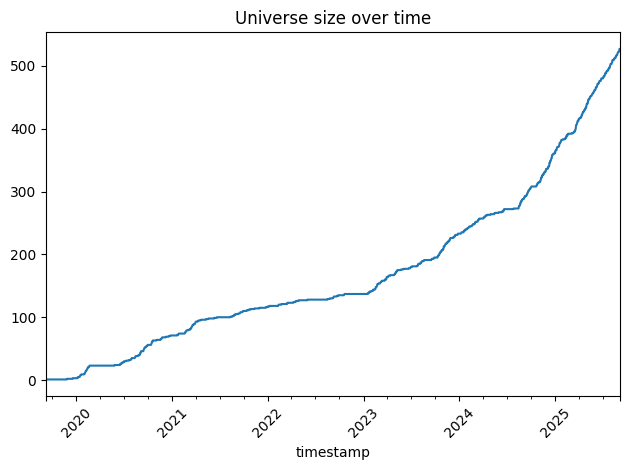

In [2]:
# plot universe size over time
df.groupby('timestamp').size().plot()
plt.title("Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

In [3]:
# Add forward returns
def add_n_day_forward_returns(df, n):
	# print(f"Adding {n} period forward returns")
	df[f"fwd_return_{n}d"] = (
		df.groupby("symbol")["close"]
		.transform(lambda x: x.shift(-n) / x - 1)
	)
	
	# Define a helper that computes the future sum using reversed rolling window
	def future_sum(series, n):
		# Reverse the series so that future values become the "past"
		rev = series.iloc[::-1]
		# Compute a rolling sum on the reversed series; use min_periods=n to only include rows with a full window
		rolled = rev.rolling(window=n, min_periods=n).sum().iloc[::-1]
		# Shift by -1 to align each row with the sum of the NEXT n periods (i.e., skip the current row)
		return rolled.shift(-1)
	
	# Apply the helper to each group and make sure to reset the index to match df
	df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
									   .apply(lambda s: future_sum(s, n)) \
									   .reset_index(level=0, drop=True)
	# combined
	df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
	return df

for n in range(1, 61):
	df = add_n_day_forward_returns(df, n)

# make vol a mix of long term(using expanding window) and short term (using ewm)
df['return'] = df.groupby('symbol')['close'].pct_change()
df['vol_expanding_window'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.expanding(min_periods=30)
					.std())
)
df['vol_ewm'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.ewm(span=30, adjust=False, min_periods=30)
					.std())
)
df['volatility'] = (
	df['vol_expanding_window'] * 0.25 +
	df['vol_ewm'] * 0.75
)

# copy df to de-fragment it
df = df.copy()

C:\Users\itataurov\AppData\Local\Temp\ipykernel_17328\537469428.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
C:\Users\itataurov\AppData\Local\Temp\ipykernel_17328\537469428.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
C:\Users\itataurov\AppData\Local\Temp\ipykernel_17328\537469428.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [4]:
# Universe selection
df['dollar_volume'] = df['close'] * df['volume']
df['dollar_volume_slowed'] = (
	df.groupby('symbol')['dollar_volume']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['dv_rank'] = (
	df.groupby('timestamp')['dollar_volume_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)

df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['mc_rank'] = (
	df.groupby('timestamp')['market_cap_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)

# Filter illiquids 

In [ ]:
# Select universe
df_filtered = df[df.dollar_volume_slowed >= 1e6]
df_filtered = df_filtered[df_filtered.timestamp<'2025-01-01']
df_filtered = df_filtered[df_filtered.timestamp>'2021-01-01']
print(f"Filtered down from {len(df)} to {len(df_filtered)} rows")

Filtered down from 374066 to 239339 symbols


In [7]:
# demean forward returns (old + slow)
# for n in range(1, 61):
# 	print(f"Demeaning forward returns {n}")
# 	df_filtered[f'fwd_return_{n}d_demeaned'] = df_filtered.groupby('timestamp')[f'fwd_return_{n}d'].transform(lambda x: x - x.mean())
# 	df_filtered[f'fwd_funding_return_{n}d_demeaned'] = df_filtered.groupby('timestamp')[f'fwd_funding_return_{n}d'].transform(lambda x: x - x.mean())
# 	# combined
# 	df_filtered[f'fwd_combined_return_{n}d_demeaned'] = df_filtered.groupby('timestamp')[f'fwd_combined_return_{n}d'].transform(lambda x: x - x.mean())

# 1) define your three 60-column groups
price_cols    = [f"fwd_return_{n}d"          for n in range(1, 61)]
funding_cols  = [f"fwd_funding_return_{n}d"  for n in range(1, 61)]
combined_cols = [f"fwd_combined_return_{n}d" for n in range(1, 61)]

# 2) vectorized demean in-place, naming *_demeaned_fast
for cols in (price_cols, funding_cols, combined_cols):
	# compute per-timestamp means for all cols at once
	means = df_filtered.groupby("timestamp")[cols].transform("mean")
	# subtract and assign to new *_demeaned_fast columns
	fast_cols = [f"{c}_demeaned" for c in cols]
	df_filtered[fast_cols] = df_filtered[cols] - means

df_filtered = df_filtered.copy() # de-fragment

In [11]:
df_filtered.columns[0:30]

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'buy_trades_perp', 'total_trades_perp', 'spot_close',
       'buy_volume_spot', 'total_volume_spot', 'buy_trades_spot',
       'total_trades_spot', 'predicted_funding_rate', 'fwd_return_1d',
       'fwd_funding_return_1d', 'fwd_combined_return_1d', 'fwd_return_2d',
       'fwd_funding_return_2d', 'fwd_combined_return_2d', 'fwd_return_3d',
       'fwd_funding_return_3d', 'fwd_combined_return_3d'],
      dtype='object')

# Compute Signal

In [ ]:
def compute_signal(df, lookback, signal_name):
	df['buy_volume_perp_slowed'] = df.groupby('symbol')['buy_volume_perp'].transform(
		lambda x: x.ewm(span=lookback).mean()
	)
	df['total_volume_perp_slowed'] = df.groupby('symbol')['volume'].transform(
		lambda x: x.ewm(span=lookback).mean()
	)
	df[signal_name] = df['buy_volume_perp_slowed'] / df['total_volume_perp_slowed']

	def winsorize(x, lower_pct, upper_pct):
		lo, hi = x.quantile(lower_pct), x.quantile(upper_pct)
		return x.clip(lower=lo, upper=hi)

	# df[signal_name] = (
	# 	df
	# 	.groupby('timestamp')[signal_name]
	# 	.transform(lambda x: winsorize(x, 0.05, 0.95))
	# )
	
	return df

lookbacks = [4,8,16,32,64,128]
# lookbacks = [60,120,240]

for l in lookbacks:
	print(f"Computing signal for lookback {l}")
	df_filtered = compute_signal(df_filtered, l, f'signal_{l}d')


Computing signal for lookback 4
Computing signal for lookback 8
Computing signal for lookback 16
Computing signal for lookback 32
Computing signal for lookback 64
Computing signal for lookback 128


# Visualize signals

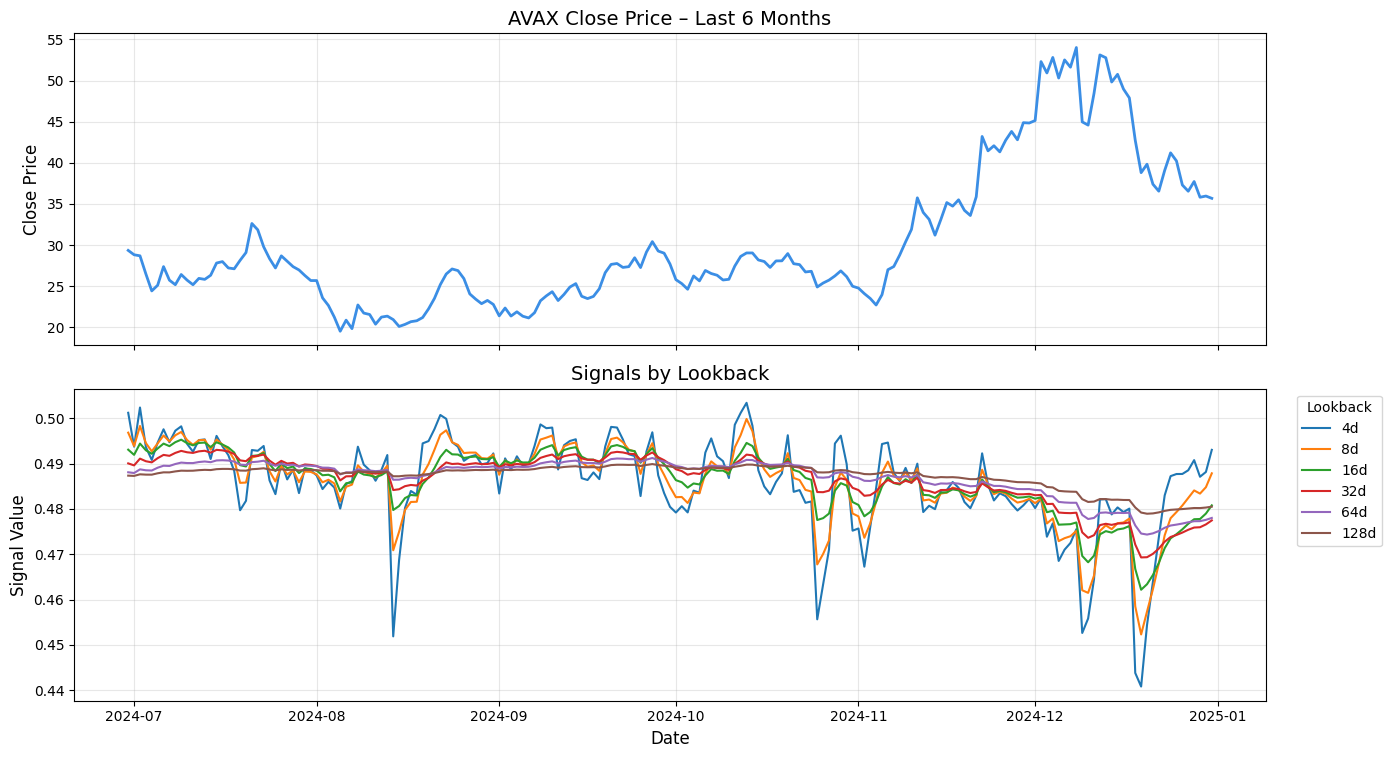

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# --- AVAX slice, last 6 months ----------------------------
btc = df_filtered[df_filtered['symbol'] == 'AVAX'].copy()
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
end   = btc['timestamp'].max()
start = end - pd.DateOffset(months=6)
btc   = btc[btc['timestamp'] >= start]

# --- plot: price on top, signals bottom (equal height) ------------------
fig, (ax1, ax2) = plt.subplots(
	nrows=2,
	ncols=1,
	sharex=True,
	figsize=(14, 8),
	gridspec_kw={"height_ratios": [1, 1]}  # equal heights
)

# Top: AVAX price
ax1.plot(btc['timestamp'], btc['close'], color="#3B8EE5", lw=2)
ax1.set_ylabel('Close Price', fontsize=12)
ax1.set_title('AVAX Close Price – Last 6 Months', fontsize=14)
ax1.grid(True, alpha=0.3)

# Bottom: signals
for l in lookbacks:
	ax2.plot(
		btc['timestamp'],
		btc[f'signal_{l}d'],
		lw=1.5,
		label=f'{l}d'
	)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Signal Value', fontsize=12)
ax2.set_title('Signals by Lookback', fontsize=14)
ax2.legend(
	title='Lookback',
	bbox_to_anchor=(1.02, 1),
	loc='upper left'
)
ax2.grid(True, alpha=0.3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Lookback selection

### IC vs lookback

4
8
16
32
64
128


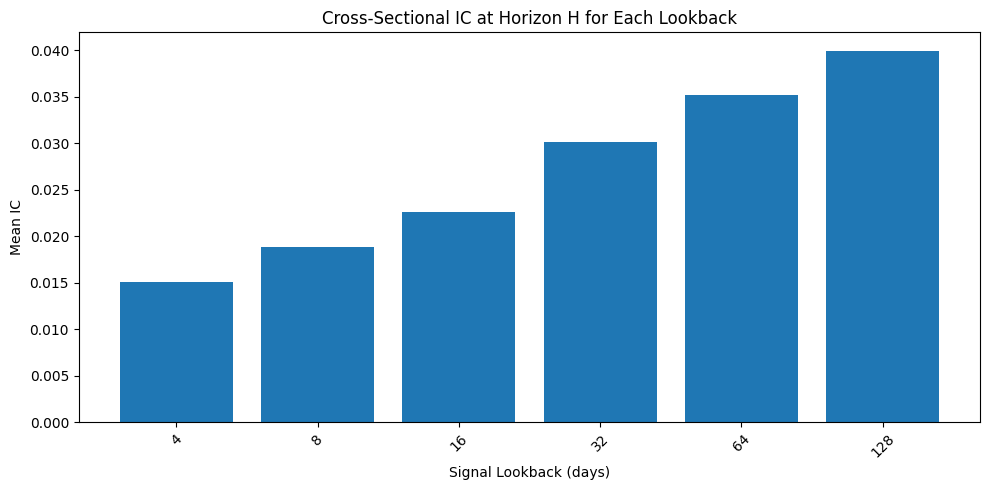

          avg_turnover  avg_hold_days  horizon_H        IC
lookback                                                  
4             0.525286       1.903727          2  0.015044
8             0.326990       3.058196          3  0.018839
16            0.195887       5.104994          5  0.022611
32            0.117519       8.509296          9  0.030169
64            0.073951      13.522523         14  0.035193
128           0.050086      19.965527         20  0.039954


In [19]:
results = []

for l in lookbacks:
	print(l)
	sig_col = f"signal_{l}d"

	# ——— 1) build the raw signal matrix, with NaNs for missing symbols ———
	S = df_filtered.pivot(
		index="timestamp",
		columns="symbol",
		values=sig_col,
	)  # missing value -> NaN

	# ——— 2) subtract the cross‐sectional mean (skipna=True by default) ———
	S0 = S.sub(S.mean(axis=1), axis=0)

	# ——— 3) normalize by the sum of abs deviations (skipna=True) ———
	norm = S0.abs().sum(axis=1)
	W = S0.div(norm, axis=0)

	# ——— 4) put missing positions back to 0 (just like your unstack(fill_value=0)) ———
	W = W.fillna(0)

	# ——— 5) turnover exactly as before ———
	daily_turnover = W.diff().abs().sum(axis=1).iloc[1:]
	avg_turn       = daily_turnover.mean()
	avg_hold       = 1.0 / avg_turn
	H              = int(round(avg_hold))

	# ——— 6) horizon‐matched IC exactly as before ———
	ret_col   = f"fwd_combined_return_{H}d_demeaned"
	daily_ics = (
		df_filtered
		.groupby("timestamp")[[sig_col, ret_col]]
		.apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2))
		.dropna()
	)
	ic_H = daily_ics.mean()

	results.append({
		"lookback":      l,
		"avg_turnover":  avg_turn,
		"avg_hold_days": avg_hold,
		"horizon_H":     H,
		"IC":            ic_H,
	})

metrics = pd.DataFrame(results).set_index("lookback")

plt.figure(figsize=(10, 5))
plt.bar(metrics.index.astype(str), metrics["IC"])
plt.title("Cross-Sectional IC at Horizon H for Each Lookback")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Mean IC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(metrics)


### Theoretical IR vs lookback

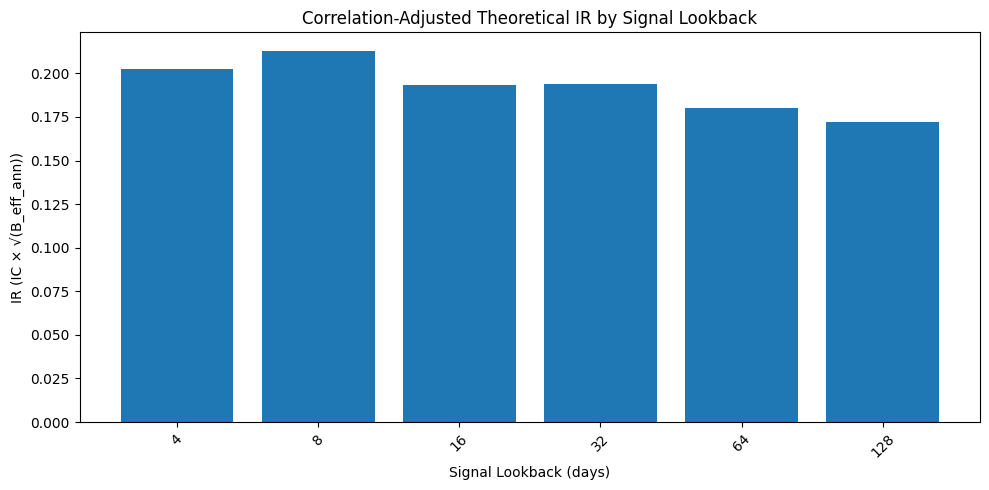

          avg_turnover  avg_hold_days  horizon_H        IC   rho_avg  \
lookback                                                               
4             0.525286       1.903727          2  0.011007  0.536979   
8             0.326990       3.058196          3  0.014027  0.526873   
16            0.195887       5.104994          5  0.016753  0.545889   
32            0.117519       8.509296          9  0.022613  0.548762   
64            0.073951      13.522523         14  0.026419  0.558887   
128           0.050086      19.965527         20  0.030315  0.564654   

           B_eff_ann  IR_uncorr  IR_corr_adj  
lookback                                      
4         338.994161   0.148694     0.202656  
8         230.306597   0.154724     0.212876  
16        133.396597   0.143140     0.193496  
32         73.723307   0.144009     0.194163  
64         46.539517   0.134896     0.180231  
128        32.246670   0.129507     0.172149  


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) One-time pivots
# ────────────────────────────────────────────
# pivot close-prices once
C = df_filtered.pivot(index="timestamp", columns="symbol", values="close")

# pivot each signal lookback once
pivot_signals = {
	l: df_filtered.pivot(index="timestamp", columns="symbol", values=f"signal_{l}d")
	for l in lookbacks
}

results = []

for l in lookbacks:
	# 1) Cross-sectional weights & turnover
	# ────────────────────────────────────────────
	S   = pivot_signals[l]                     # (Timestamps × Symbols)
	S0  = S.sub(S.mean(axis=1), axis=0)        # de-mean each row
	norm= S0.abs().sum(axis=1)                 # ∑ |deviation|
	W   = S0.div(norm, axis=0).fillna(0)       # normalize & fill missing=0

	daily_turnover = W.diff().abs().sum(axis=1).iloc[1:]
	avg_turn       = daily_turnover.mean()
	avg_hold       = 1.0 / avg_turn
	H              = int(round(avg_hold))

	# 2) Horizon-matched IC
	# ────────────────────────────────────────────
	Ret = C.shift(-H).div(C) - 1               # forward returns matrix
	# de-mean both cross-sections
	X0  = S.sub( S.mean(axis=1), axis=0)
	Y0  = Ret.sub(Ret.mean(axis=1), axis=0)

	# element-wise sums for corr numerator/denominator
	cov_xy = (X0 * Y0).sum(axis=1)
	var_x  = (X0 * X0).sum(axis=1)
	var_y  = (Y0 * Y0).sum(axis=1)

	# only keep days with ≥2 assets
	valid = (S.notna() & Ret.notna()).sum(axis=1) >= 2

	daily_ic = cov_xy.div(np.sqrt(var_x * var_y))
	ic_H     = daily_ic[valid].mean()

	# 3) Correlation-adjusted breadth & IR
	# ────────────────────────────────────────────
	corr = Ret.corr(min_periods=1)
	n    = corr.shape[0]
	if n > 1:
		off = corr.values[~np.eye(n, dtype=bool)]
		rho = np.nanmean(off)
	else:
		rho = 0.0

	B_eff       = n / (1 + (n - 1) * rho)
	B_eff_ann   = B_eff * (365.0 / H)
	ir_uncorr   = ic_H * np.sqrt(365.0 / H)
	ir_corr_adj = ic_H * np.sqrt(B_eff_ann)

	results.append({
		"lookback":      l,
		"avg_turnover":  avg_turn,
		"avg_hold_days": avg_hold,
		"horizon_H":     H,
		"IC":            ic_H,
		"rho_avg":       rho,
		"B_eff_ann":     B_eff_ann,
		"IR_uncorr":     ir_uncorr,
		"IR_corr_adj":   ir_corr_adj
	})

# 4) Build & plot
# ────────────────────────────────────────────
metrics = pd.DataFrame(results).set_index("lookback")

plt.figure(figsize=(10,5))
plt.bar(metrics.index.astype(str), metrics["IR_corr_adj"])
plt.title("Correlation-Adjusted Theoretical IR by Signal Lookback")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("IR (IC × √(B_eff_ann))")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(metrics)


### Backtested sharpe vs lookback

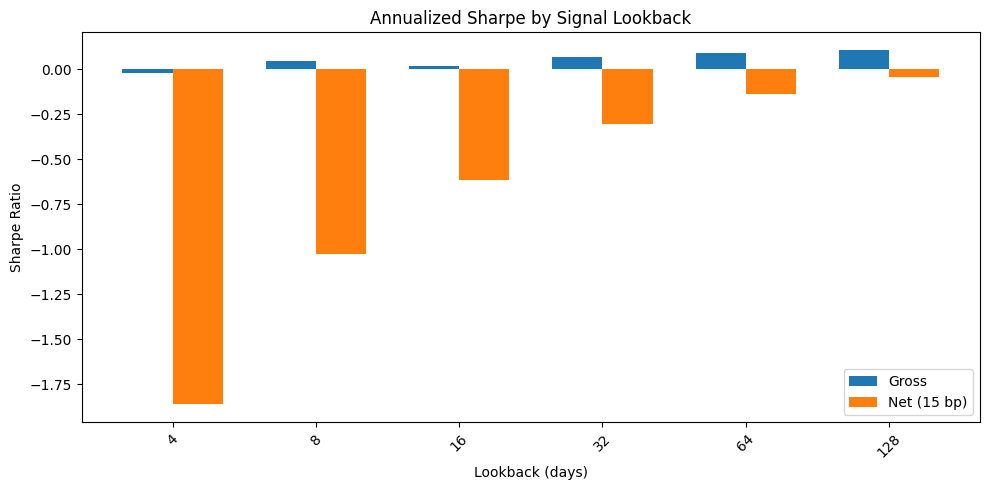

In [21]:
def backtest_strategy(
		df: pd.DataFrame,
		signal_col: str,
		funding_col: str = 'fundingRate',
		start_date: str | pd.Timestamp = '2022-01-01',
		trading_days: int = 365,
		fee: float = 0.0015
	):
	"""
	Cross-sectional back-test that includes one-day funding cash-flows.

	Parameters
	----------
	df : pd.DataFrame
		Must contain columns:
			['symbol', 'timestamp', signal_col,
			 'fwd_return_1d', funding_col]
		▸ `fwd_return_1d`  : price return from t → t+1
		▸ `funding_col`    : realised funding from t-1 → t
	signal_col : str
		Name of the alpha signal.
	funding_col : str, default 'fundingRate'
		Name of the raw funding column (t-1 → t).
	start_date : str or pd.Timestamp
		Back-test uses rows with timestamp > start_date.
	trading_days : int
		Annualisation factor for Sharpe.
	fee : float
		Round-trip fee per unit turnover (e.g. 0.0015 = 15 bp).

	Returns
	-------
	strategy_returns : pd.Series   (gross P&L, GMV = 1)
	sharpe_gross     : float       (annualised)
	net_returns      : pd.Series   (after fees)
	sharpe_net       : float       (annualised)
	daily_turnover   : pd.Series   (∑|Δw|)
	"""
	# ------------------------------------------------------------------ 1/6
	df_bt = (
		df.loc[lambda d: d['timestamp'] > start_date]
		  .copy()
		  .sort_values(['symbol', 'timestamp'])
		  .reset_index(drop=True)
	)

	# Safety: make sure funding exists and fill gaps
	if funding_col not in df_bt.columns:
		df_bt[funding_col] = 0.0
	df_bt[funding_col] = df_bt[funding_col].fillna(0.0)

	# ------------------------------------------------------------------ 2/6
	# Cross-sectional z-score to get dollar-neutral weights
	df_bt['weight'] = (
		df_bt
		.groupby('timestamp')[signal_col]
		.transform(lambda x: (x - x.mean()) / (x - x.mean()).abs().sum())
	)

	# ------------------------------------------------------------------ 3/6
	# Align funding with NEXT day’s price return ------------------------
	df_bt['funding_fwd1d'] = (
		df_bt
		.groupby('symbol')[funding_col]
		.shift(-1)                # t-1→t moves to row t
		.fillna(0.0)              # last row per symbol → 0
	)

	strategy_returns = (
		df_bt['weight']
		* (df_bt['fwd_return_1d'] + df_bt['funding_fwd1d'])
	).groupby(df_bt['timestamp']).sum()

	# ------------------------------------------------------------------ 4/6
	W = (
		df_bt
		.pivot(index='timestamp', columns='symbol', values='weight')
		.fillna(0.0)
	)
	daily_turnover = W.diff().abs().sum(axis=1).fillna(0.0)

	turnover = daily_turnover.reindex(strategy_returns.index).fillna(0.0)
	net_returns = strategy_returns - fee * turnover

	# ------------------------------------------------------------------ 5/6
	sharpe_gross = (
		strategy_returns.mean() /
		strategy_returns.std(ddof=0) * np.sqrt(trading_days)
	)
	sharpe_net = (
		net_returns.mean() /
		net_returns.std(ddof=0) * np.sqrt(trading_days)
	)

	# ------------------------------------------------------------------ 6/6
	return strategy_returns, sharpe_gross, net_returns, sharpe_net, daily_turnover

# === now loop over lookbacks ===
results = []
ret_series_gross = {}
ret_series_net   = {}

for l in lookbacks:
	sig = f"signal_{l}d"
	rets_g, sr_g, rets_n, sr_n, turnover = backtest_strategy(
		df_filtered, sig, start_date='2022-01-01', trading_days=252, fee=0.0015
	)
	results.append({
		'lookback':     l,
		'Sharpe_gross': sr_g,
		'Sharpe_net':   sr_n
	})
	ret_series_gross[l] = rets_g
	ret_series_net[l]   = rets_n

# build DataFrame of Sharpe
sharpe_df = pd.DataFrame(results).set_index('lookback')

# grouped bar‐plot of gross vs net Sharpe
x     = np.arange(len(sharpe_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, sharpe_df['Sharpe_gross'], width, label='Gross')
ax.bar(x + width/2, sharpe_df['Sharpe_net'],   width, label='Net (15 bp)')

ax.set_title("Annualized Sharpe by Signal Lookback")
ax.set_xlabel("Lookback (days)")
ax.set_ylabel("Sharpe Ratio")
ax.set_xticks(x)
ax.set_xticklabels(sharpe_df.index.astype(str), rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


# Signal Selection

In [22]:
df_filtered['signal'] = df_filtered['signal_128d']

Holding-period estimator ``H = 1/avg_turnover`` assumes ``GMV = 1``.

In [24]:
# find turnover for future plots
df_filtered['weight'] = df_filtered.groupby('timestamp')['signal'].transform(
		lambda x: (x - x.mean()) / (x - x.mean()).abs().sum()
)
W = df_filtered.pivot(values='weight', columns='symbol', index='timestamp')
avg_holding_period = 1/W.diff().abs().sum(axis=1).mean()
print(f"Avg holding period: {avg_holding_period:.2f}")

Avg holding period: 20.82


# Signal distribution

Five-number summary:
  Min     : 0.4134
  25th %ile: 0.4824
  Median  : 0.4872
  75th %ile: 0.4916
  Max     : 0.5051


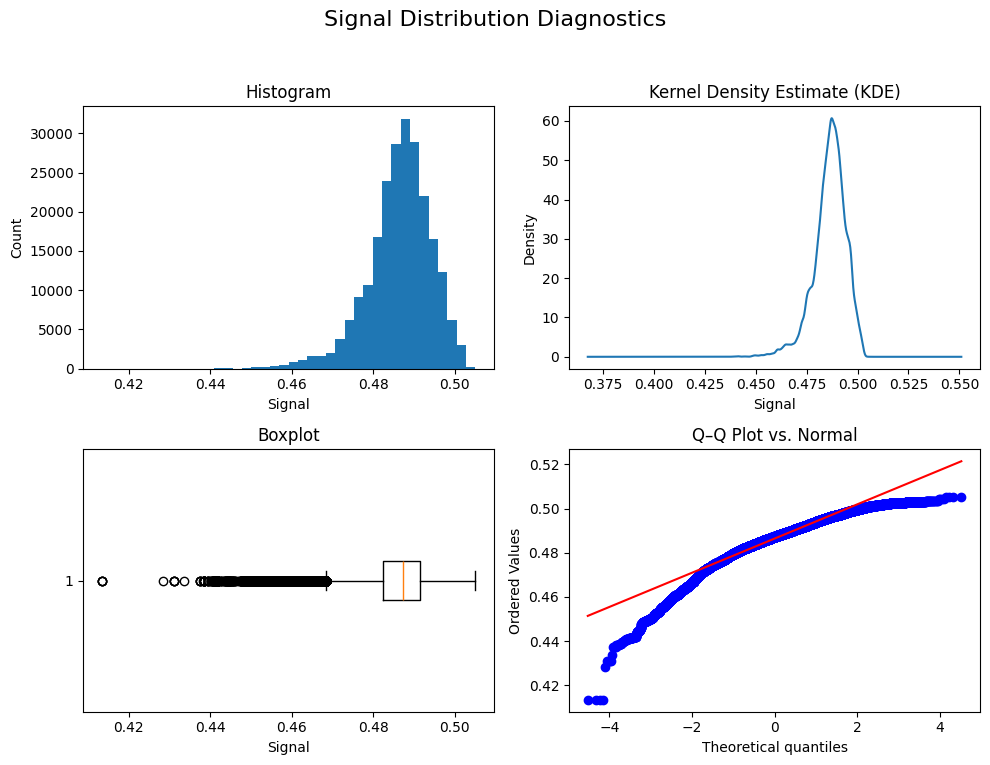

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# extract and clean
signal = df_filtered['signal'].dropna()

# compute five-number summary
five_num = signal.quantile([0, .25, .5, .75, 1.0])
print("Five-number summary:")
print(f"  Min     : {five_num.loc[0.00]:.4f}")
print(f"  25th %ile: {five_num.loc[0.25]:.4f}")
print(f"  Median  : {five_num.loc[0.50]:.4f}")
print(f"  75th %ile: {five_num.loc[0.75]:.4f}")
print(f"  Max     : {five_num.loc[1.00]:.4f}")

# set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Signal Distribution Diagnostics', fontsize=16)

# 1. Histogram
axes[0, 0].hist(signal, bins=40)
axes[0, 0].set_title('Histogram')
axes[0, 0].set_xlabel('Signal')
axes[0, 0].set_ylabel('Count')

# 2. KDE
signal.plot.kde(ax=axes[0, 1])
axes[0, 1].set_title('Kernel Density Estimate (KDE)')
axes[0, 1].set_xlabel('Signal')

# 3. Boxplot
axes[1, 0].boxplot(signal, vert=False)
axes[1, 0].set_title('Boxplot')
axes[1, 0].set_xlabel('Signal')

# 4. Q–Q Plot
st.probplot(signal, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q–Q Plot vs. Normal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Signal performance

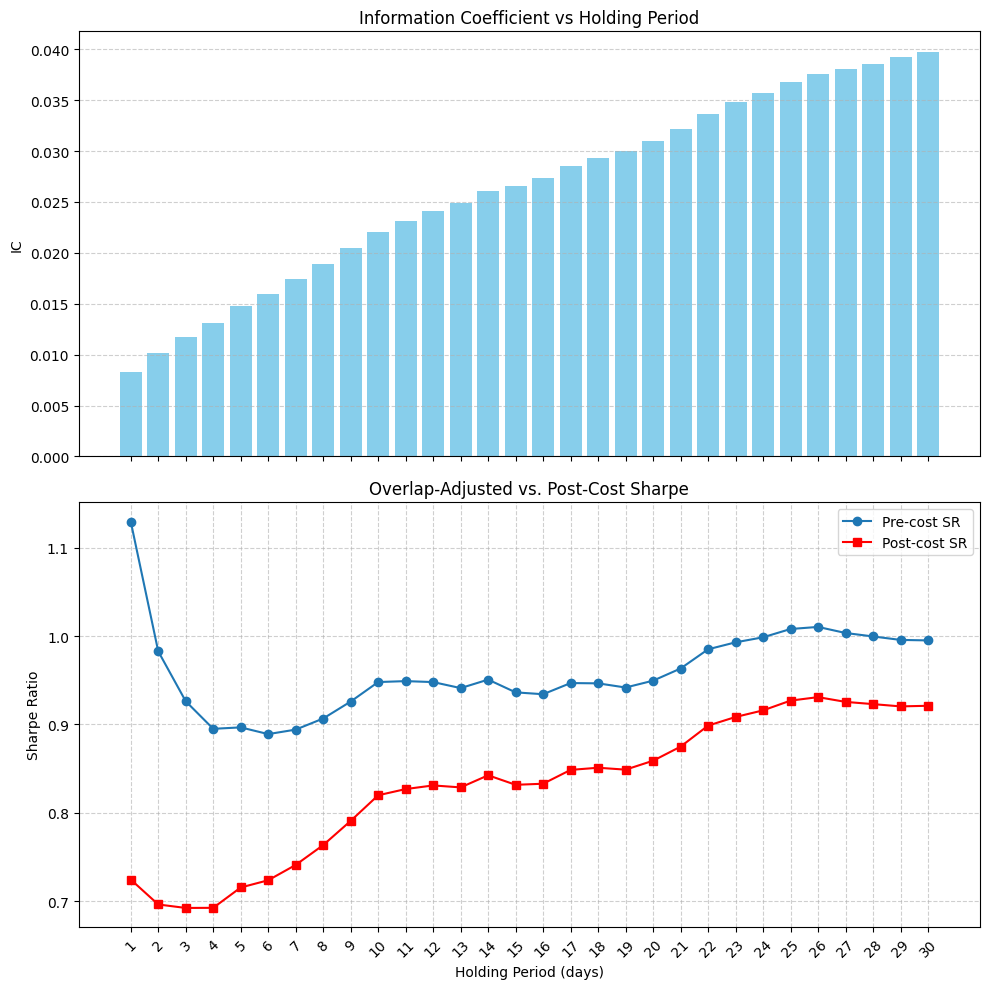

In [829]:
import numpy as np
import matplotlib.pyplot as plt

spans          = range(1, 31)
signal         = 'weight'
trading_days   = 365
n_assets       = 50
cost_per_trade = 30e-4

ic_vals      = []
sr_pre_vals  = []
sr_post_vals = []

for h in spans:
	# ret_col = f'fwd_combined_return_{h}d_demeaned'
	ret_col = f'fwd_return_{h}d_demeaned'
	ic = df_filtered[signal].corr(df_filtered[ret_col])
	rho_h = df_filtered[ret_col].autocorr(lag=1)
	B_eff = (trading_days/h) * (1 - rho_h)/(1 + rho_h) * n_assets

	sr_pre = ic * np.sqrt(max(B_eff, 0))
	# **new** cost drag
	trades_per_year = trading_days / h
	cost_drag       = cost_per_trade * np.sqrt(trades_per_year * n_assets)

	sr_post = sr_pre - cost_drag

	ic_vals.append(ic)
	sr_pre_vals.append(sr_pre)
	sr_post_vals.append(sr_post)

fig, (ax_ic, ax_sr) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax_ic.bar(spans, ic_vals, color='skyblue')
ax_ic.set_ylabel('IC')
ax_ic.set_title('Information Coefficient vs Holding Period')
ax_ic.grid(axis='y', linestyle='--', alpha=0.6)

ax_sr.plot(spans, sr_pre_vals,  marker='o', label='Pre‑cost SR')
ax_sr.plot(spans, sr_post_vals, marker='s', label='Post‑cost SR', color='red')
ax_sr.set_xlabel('Holding Period (days)')
ax_sr.set_ylabel('Sharpe Ratio')
ax_sr.set_title('Overlap‑Adjusted vs. Post‑Cost Sharpe')
ax_sr.grid(linestyle='--', alpha=0.6)
ax_sr.legend()

plt.xticks(spans, rotation=45)
plt.tight_layout()
plt.show()


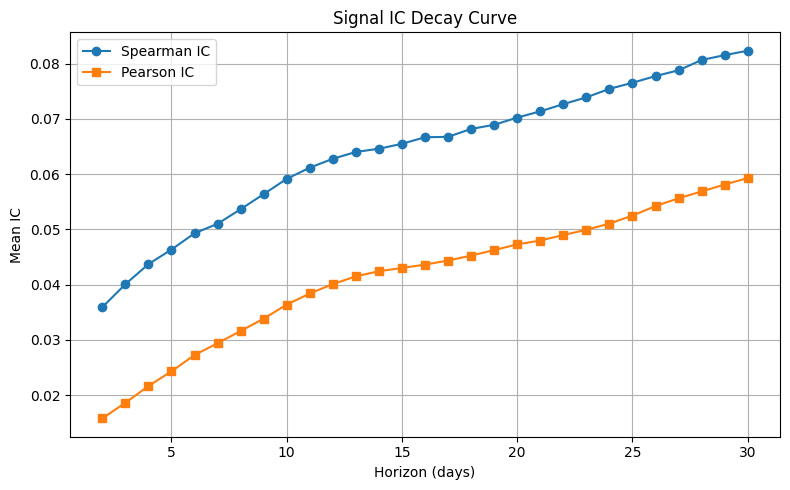

In [830]:
# 2. Define horizons and corresponding column names
horizons = range(2, 31)
horizon_cols = [f'fwd_return_{h}d' for h in horizons]
# 3. Pivot out your “signal” into a wide matrix (timestamps × symbols)
sig_wide = (
	df_filtered
	  .dropna(subset=['signal'] + horizon_cols)
	  .pivot(index='timestamp', columns='symbol', values='signal')
)

spearman_ics = []
pearson_ics  = []

# 4. Pre-define a helper to pivot each forward‐return
def pivot_return(h):
	return (
		df_filtered
		  .dropna(subset=['signal', f'fwd_return_{h}d'])
		  .pivot(index='timestamp', columns='symbol', values=f'fwd_return_{h}d')
		  .reindex_like(sig_wide)
	)

# 5. Loop horizons with vectorized corrwith
for h in horizons:
	ret_wide = pivot_return(h)

	# Pearson IC: simple row‐wise corr
	pearson_per_day  = sig_wide.corrwith(ret_wide, axis=1)

	# Spearman IC: rank‐then‐corr
	spearman_per_day = (
		sig_wide
		.rank(axis=1)
		.corrwith(ret_wide.rank(axis=1), axis=1)
	)

	pearson_ics.append(pearson_per_day.mean())
	spearman_ics.append(spearman_per_day.mean())

# 6. Plot as before
plt.figure(figsize=(8,5))
plt.plot(horizons, spearman_ics, marker='o', label='Spearman IC')
plt.plot(horizons,  pearson_ics, marker='s', label='Pearson IC')
plt.xlabel('Horizon (days)')
plt.ylabel('Mean IC')
plt.title('Signal IC Decay Curve')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     152.8
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           4.53e-35
Time:                        00:57:37   Log-Likelihood:                -12082.
No. Observations:               89199   AIC:                         2.417e+04
Df Residuals:                   89197   BIC:                         2.419e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.001      4.804      0.0

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_946/2110750711.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')[[predictor, response]]


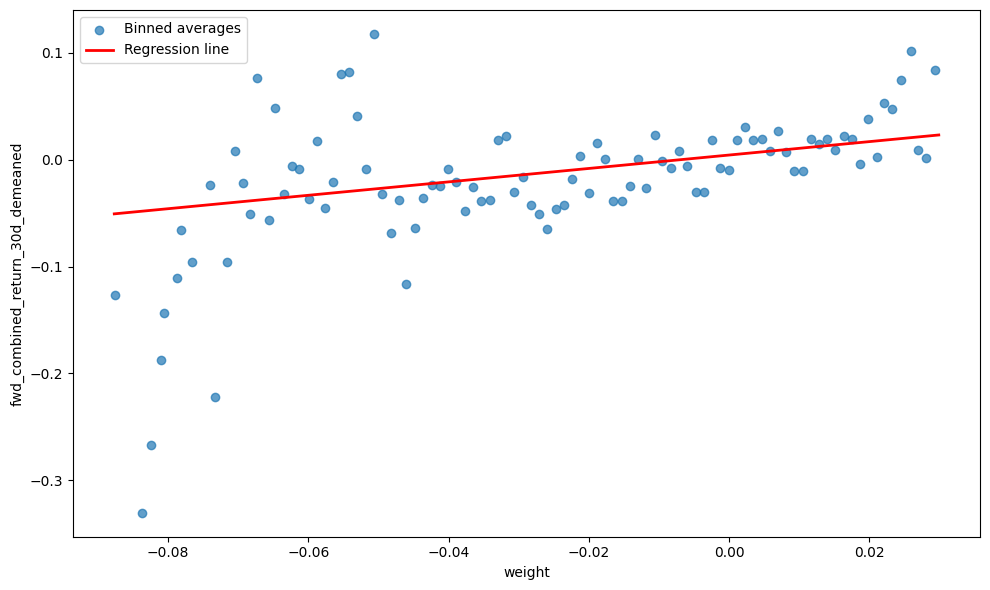

In [831]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# ──────────────── PARAMETERS ─────────────────
predictor   = 'weight' # weight
response = f'fwd_combined_return_{max(min(int(avg_holding_period),30), 1)}d_demeaned' # fwd_combined_return_1d_demeaned

# Regression settings
do_binning = True    # set False if you want to scatter all raw points
n_bins     = 100     # only used if do_binning is True

# ─────────────── DATA PREP & REGRESSION ───────────────
# 1) Drop any NaNs in the two columns we care about
data = df_filtered.dropna(subset=[predictor, response])

# 2) Extract X, y for sklearn & statsmodels
X = data[[predictor]].values
y = data[[response]].values

# 3) Fit scikit-learn LinearRegression
lr = LinearRegression().fit(X, y)

# 4) Fit statsmodels OLS for summary/stats
X_sm = sm.add_constant(X)
ols_res = sm.OLS(y, X_sm).fit()
print(ols_res.summary())
print(f"R^2: {ols_res.rsquared:.5f}")
print(f"sqrt(R^2): {np.sqrt(ols_res.rsquared):.3f}")

# ─────────────── PLOTTING ───────────────
plt.figure(figsize=(10, 6))

if do_binning:
	# build a small DataFrame for easy grouping
	df_plot = pd.DataFrame({
		predictor: X.flatten(),
		response: y.flatten()
	})
	df_plot['bin'] = pd.cut(df_plot[predictor], bins=n_bins)
	
	binned = (
		df_plot
		.groupby('bin')[[predictor, response]]
		.mean()
		.reset_index(drop=True)
	)
	plt.scatter(binned[predictor], binned[response],
				alpha=0.7, label='Binned averages')
else:
	plt.scatter(X.flatten(), y.flatten(),
				alpha=0.3, label='Raw data')

# regression line over full range
x_line = np.linspace(X.min(), X.max(), 100)
y_line = lr.predict(x_line.reshape(-1, 1))
plt.plot(x_line, y_line, color='red', linewidth=2, label='Regression line')

plt.xlabel(predictor)
plt.ylabel(response)
plt.legend()
plt.tight_layout()
plt.show()


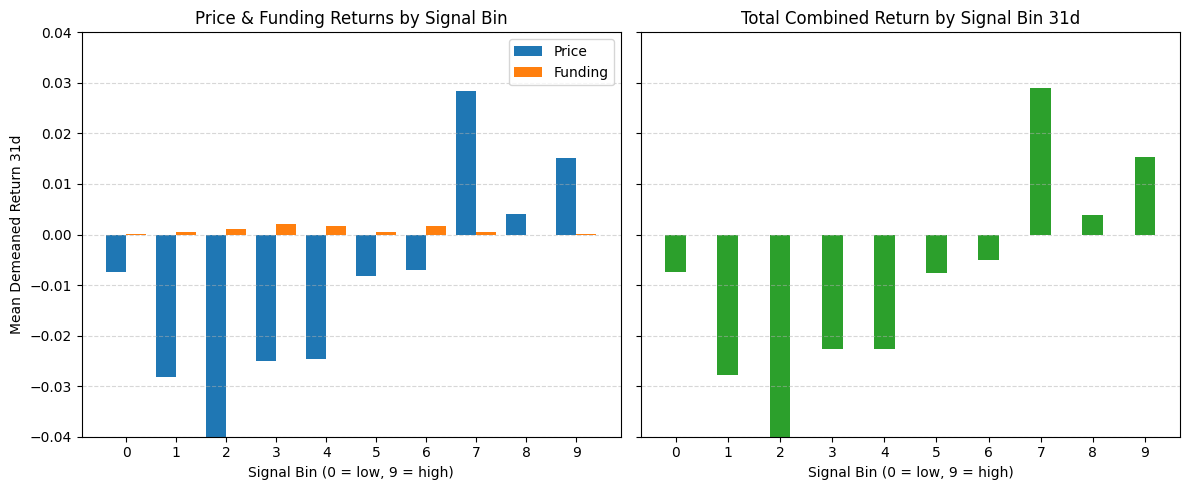

In [832]:
# 1) Prepare the data once
h = int(avg_holding_period)
response_price   = f'fwd_return_{h}d_demeaned'
response_fund    = f'fwd_funding_return_{h}d_demeaned'
response_total   = f'fwd_combined_return_{h}d_demeaned'

df2 = (
		df_filtered
			.dropna(subset=['signal', response_price, response_fund, response_total])
			.copy()
)
df2['signal_bin'] = (
		df2.groupby('timestamp')['signal']
			 .transform(lambda x: pd.cut(x, 10, labels=False))
)

grouped = df2.groupby('signal_bin')[[response_price, response_fund, response_total]].mean()
# invert funding sign so that “higher signal ⇒ more sell‐side flow” is positive
grouped[response_fund] *= -1

# 2) Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

x = np.arange(len(grouped))
width = 0.4

# Left: price + funding
axes[0].bar(x - width/2, grouped[response_price], width, label='Price')
axes[0].bar(x + width/2, grouped[response_fund],  width, label='Funding')
axes[0].set_title('Price & Funding Returns by Signal Bin')
axes[0].set_xlabel('Signal Bin (0 = low, 9 = high)')
axes[0].set_ylabel(f'Mean Demeaned Return {h}d')
axes[0].set_xticks(x)
axes[0].set_ylim(-0.04, 0.04)
axes[0].set_xticklabels(grouped.index.astype(str))
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Right: total combined
axes[1].bar(x, grouped[response_total], width, color='tab:green')
axes[1].set_title(f'Total Combined Return by Signal Bin {h}d')
axes[1].set_xlabel('Signal Bin (0 = low, 9 = high)')
axes[1].set_xticks(x)
axes[1].set_ylim(-0.04, 0.04)
axes[1].set_xticklabels(grouped.index.astype(str))
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Basic backtest

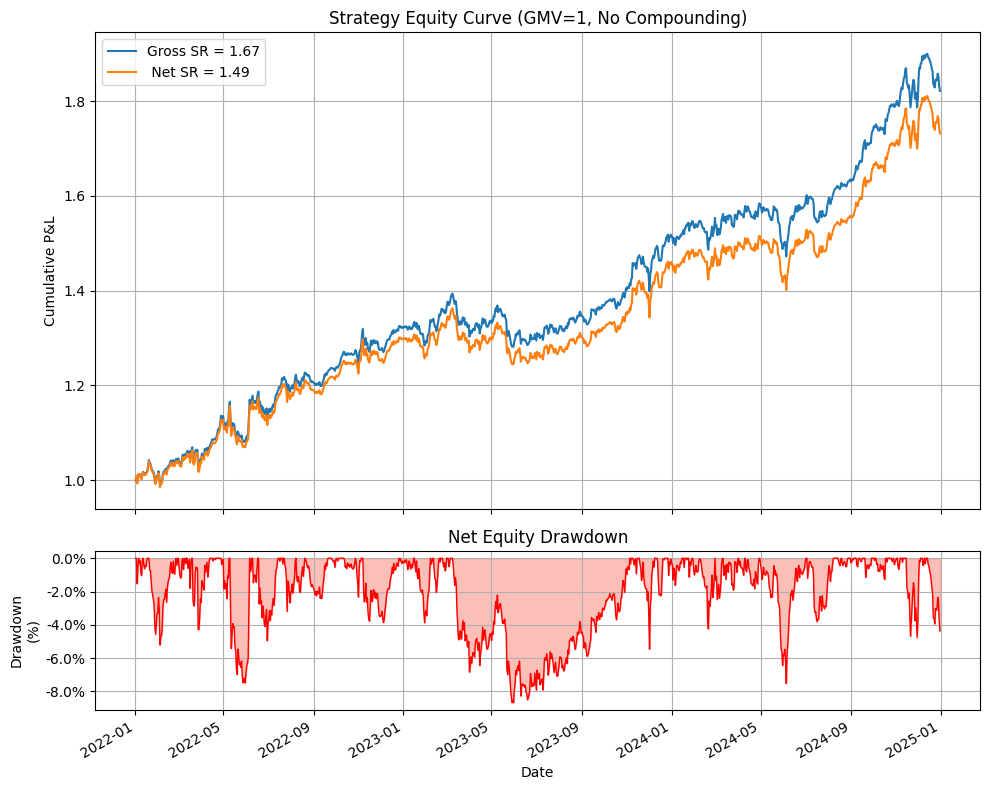

In [833]:
gross_ret,gross_sr,net_ret,net_sr,turnover_series = backtest_strategy(df_filtered, 'signal', start_date='2022-01-01', trading_days=365, fee=0.0015)

# 6) Build equity curves (no compounding)
equity_gross = 1+gross_ret.cumsum()
equity_net   = 1+net_ret.cumsum()

# 6.1) Compute % drawdown of net equity
dd = equity_net / equity_net.cummax() - 1

# 7) Plot equity and drawdown in two stacked axes
fig, (ax_eq, ax_dd) = plt.subplots(
	nrows=2, ncols=1,
	sharex=True,
	figsize=(10,8),
	gridspec_kw={'height_ratios': [3, 1]}
)
fig.autofmt_xdate()

# Equity curves
ax_eq.plot(equity_gross.index, equity_gross, label=f'Gross SR = {gross_sr:.2f}')
ax_eq.plot(equity_net.index,   equity_net,   label=f' Net SR = {net_sr:.2f}')
ax_eq.set_title("Strategy Equity Curve (GMV=1, No Compounding)")
ax_eq.set_ylabel("Cumulative P&L")
ax_eq.legend(loc='upper left')
ax_eq.grid(True)

# Drawdown plot (%)
ax_dd.fill_between(dd.index, dd, 0, color='salmon', alpha=0.5)
ax_dd.plot(dd.index, dd, color='red', lw=1)
ax_dd.set_title("Net Equity Drawdown")
ax_dd.set_ylabel("Drawdown\n(%)")
ax_dd.set_xlabel("Date")
ax_dd.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.1f}%"))
ax_dd.grid(True)

plt.tight_layout()
plt.show()



/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_946/2387614762.py:71: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  W_reb


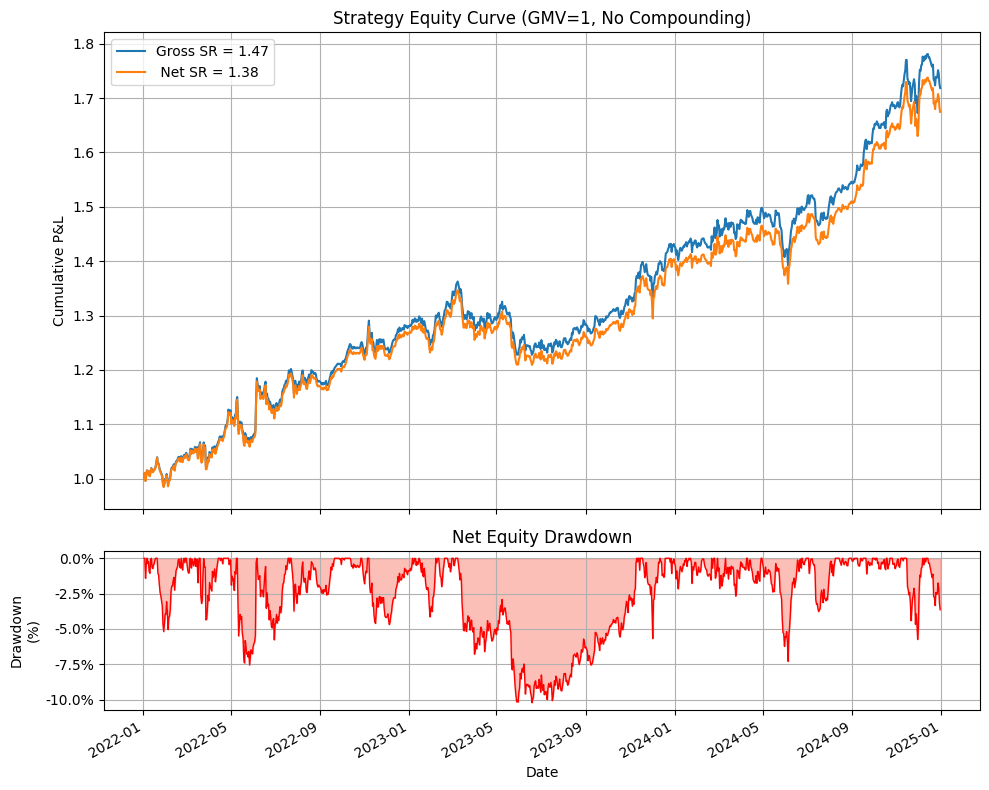

In [834]:
import numpy as np
import pandas as pd

def backtest_strategy_hold(df,
					  signal_col,
					  start_date='2022-01-01',
					  trading_days=365,
					  fee=0.0015,
					  holding_period=1):
	"""
	Backtest a cross‐sectional strategy using a given signal column,
	rebalance every `holding_period` days, and return gross/net SR and turnover.

	Parameters
	----------
	df : pd.DataFrame
		Must contain ['symbol','timestamp','close', signal_col, 'fwd_return_1d'].
	signal_col : str
		Name of the column to use as the cross‐sectional signal.
	start_date : str or pd.Timestamp
		Filter the backtest to timestamps > this date.
	trading_days : int
		Number of trading days per year for Sharpe annualization.
	fee : float
		Round‐trip fee rate per unit turnover (e.g. 0.0015 for 15 bp).
	holding_period : int
		Rebalance every `holding_period` days (1 = daily, 5 = weekly, etc.).

	Returns
	-------
	strategy_returns : pd.Series
		Daily gross P&L (GMV=1, no compounding) indexed by timestamp.
	sharpe_gross : float
		Annualized gross Sharpe.
	net_returns : pd.Series
		Daily net P&L after subtracting fee*turnover.
	sharpe_net : float
		Annualized net Sharpe.
	daily_turnover : pd.Series
		Daily portfolio turnover.
	"""
	# 1) filter & sort
	df_bt = (
		df.loc[lambda d: d['timestamp'] > start_date]
		  .copy()
		  .sort_values(['symbol','timestamp'])
	)

	# 2) pivot out returns and signals
	R = (  # forward‐1d returns pivoted
		df_bt
		.pivot(index='timestamp', columns='symbol', values='fwd_return_1d')
		.fillna(0)
	)
	S = (  # raw signal pivoted
		df_bt
		.pivot(index='timestamp', columns='symbol', values=signal_col)
	)

	# 3) pick your rebalance dates
	all_dates = R.index.unique().sort_values()
	rebalance_dates = all_dates[::holding_period]

	# 4) compute weights on rebalance days
	S_reb = S.reindex(rebalance_dates)
	demeaned = S_reb.sub(S_reb.mean(axis=1), axis=0)
	W_reb = demeaned.div(demeaned.abs().sum(axis=1), axis=0)

	# 5) carry forward weights, fill leading‐NaNs with zeros
	W = (
		W_reb
		.reindex(all_dates)           # introduce gaps
		.fillna(method='ffill')       # hold for n days
		.fillna(0)                    # before first rebalance
	)

	# 6) strategy returns & turnover
	strategy_returns = (W * R).sum(axis=1)
	daily_turnover   = W.diff().abs().sum(axis=1).fillna(0)
	net_returns      = strategy_returns - fee * daily_turnover

	# 7) annualized Sharpe
	sharpe_gross = (
		strategy_returns.mean() /
		strategy_returns.std() *
		np.sqrt(trading_days)
	)
	sharpe_net = (
		net_returns.mean() /
		net_returns.std() *
		np.sqrt(trading_days)
	)

	return strategy_returns, sharpe_gross, net_returns, sharpe_net, daily_turnover

gross_ret,gross_sr,net_ret,net_sr,turnover_series = backtest_strategy_hold(df_filtered, 'signal', start_date='2022-01-01', trading_days=365, fee=0.0015, holding_period=5)

# 6) Build equity curves (no compounding)
equity_gross = 1+gross_ret.cumsum()
equity_net   = 1+net_ret.cumsum()

# 6.1) Compute % drawdown of net equity
dd = equity_net / equity_net.cummax() - 1

# 7) Plot equity and drawdown in two stacked axes
fig, (ax_eq, ax_dd) = plt.subplots(
	nrows=2, ncols=1,
	sharex=True,
	figsize=(10,8),
	gridspec_kw={'height_ratios': [3, 1]}
)
fig.autofmt_xdate()

# Equity curves
ax_eq.plot(equity_gross.index, equity_gross, label=f'Gross SR = {gross_sr:.2f}')
ax_eq.plot(equity_net.index,   equity_net,   label=f' Net SR = {net_sr:.2f}')
ax_eq.set_title("Strategy Equity Curve (GMV=1, No Compounding)")
ax_eq.set_ylabel("Cumulative P&L")
ax_eq.legend(loc='upper left')
ax_eq.grid(True)

# Drawdown plot (%)
ax_dd.fill_between(dd.index, dd, 0, color='salmon', alpha=0.5)
ax_dd.plot(dd.index, dd, color='red', lw=1)
ax_dd.set_title("Net Equity Drawdown")
ax_dd.set_ylabel("Drawdown\n(%)")
ax_dd.set_xlabel("Date")
ax_dd.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.1f}%"))
ax_dd.grid(True)

plt.tight_layout()
plt.show()



Return AC(1): 0.034
Return mean: 0.062%


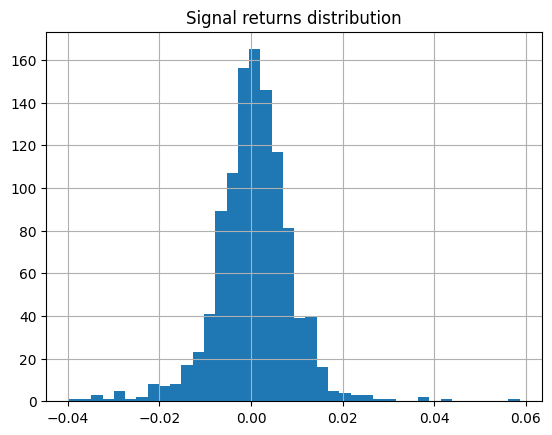

In [835]:
print(f"Return AC(1): {net_ret.autocorr(lag=1):.3f}")
print(f"Return mean: {net_ret.mean()*100:.3f}%")
net_ret.hist(bins=40)
plt.title("Signal returns distribution")
plt.show()

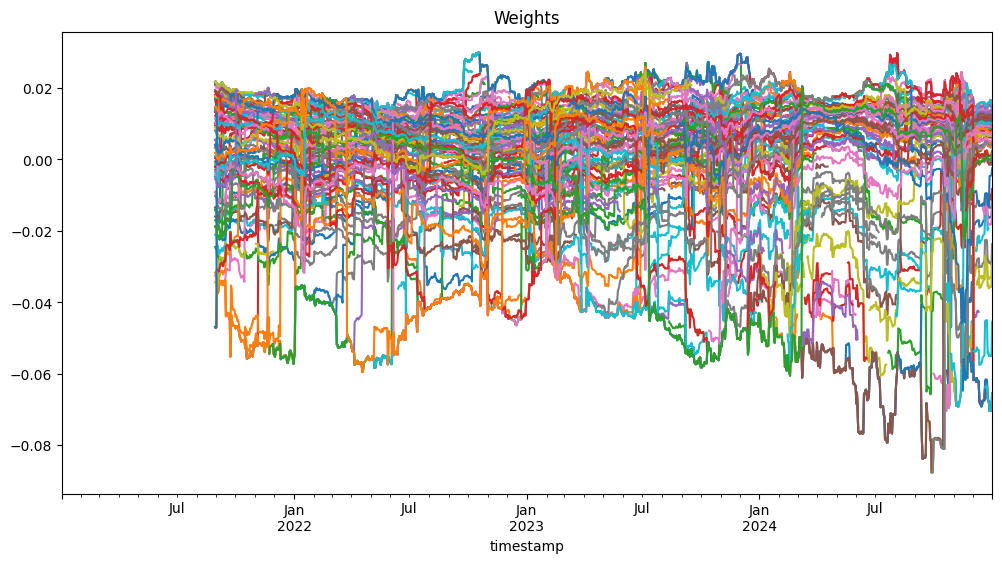

In [836]:
# Observe weights for spikes
df_filtered['weight'] = df_filtered.groupby('timestamp')['signal'].transform(
		lambda x: (x - x.mean()) / (x - x.mean()).abs().sum()
)
W = df_filtered.pivot(values='weight', columns='symbol', index='timestamp')
W.plot(legend=False, figsize=(12, 6))

plt.title("Weights")
fig.autofmt_xdate()

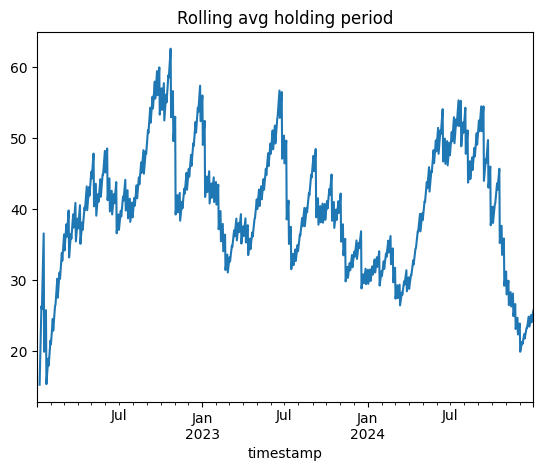

In [837]:
(1/turnover_series.ewm(span=120).mean()).plot()
plt.title("Rolling avg holding period")
plt.show()

In [838]:
# turnover
print(f"Holding period: {1/turnover_series.abs().mean():.1f}d")

Holding period: 37.4d


In [839]:
# vol per unit GMV
print(f"Vol/GMV: {gross_ret.std()*np.sqrt(365)*100:.1f}%")

Vol/GMV: 16.3%


# Regress returns against market

In [840]:
# strategy
strategy_returns = gross_ret.rename('strat_ret')
strategy_returns.index = pd.to_datetime(strategy_returns.index)
strategy_returns

# cci30 
cci30 = pd.read_csv('data/CCi30 OHLCV Data.csv')
cci30['cci30_ret'] = cci30['Close'].pct_change()
cci30 = cci30.dropna()[::-1]
cci30 = cci30.set_index('Date')['cci30_ret']
cci30.index = pd.to_datetime(cci30.index)

combined_ret = pd.concat([cci30, strategy_returns], axis=1, join="inner")
combined_ret.tail()

,cci30_ret,strat_ret
2024-12-27,-0.022178,0.000940
2024-12-28,0.028196,0.013144
2024-12-29,0.001421,-0.005925
2024-12-30,0.002292,-0.019637
2024-12-31,-0.020439,-0.007335


In [841]:
import statsmodels.api as sm

X = combined_ret[['cci30_ret']].values
y = combined_ret[['strat_ret']].values

X_sm = sm.add_constant(X)
ols_res = sm.OLS(y, X_sm).fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.057
Date:                Wed, 11 Jun 2025   Prob (F-statistic):             0.0807
Time:                        00:57:53   Log-Likelihood:                 3660.4
No. Observations:                1093   AIC:                            -7317.
Df Residuals:                    1091   BIC:                            -7307.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.572      0.0

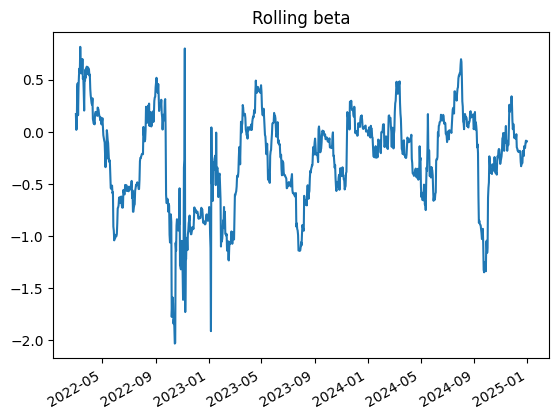

In [842]:
roll_beta = combined_ret['strat_ret'].rolling(60).corr(combined_ret['cci30_ret']) \
			 * (combined_ret['cci30_ret'].rolling(60).std() /
				 combined_ret['strat_ret'].rolling(60).std())
roll_beta.plot()
plt.title("Rolling beta")
plt.show()


### Strategy ~ market under big moves

In [843]:
# Regression under big moves
big_moves = combined_ret['cci30_ret'].abs() > combined_ret['cci30_ret'].std() * 1.5
print(sm.OLS(combined_ret.loc[big_moves,'strat_ret'],
	sm.add_constant(combined_ret.loc[big_moves,'cci30_ret'])).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              strat_ret   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.281
Date:                Wed, 11 Jun 2025   Prob (F-statistic):              0.260
Time:                        00:57:54   Log-Likelihood:                 410.90
No. Observations:                 121   AIC:                            -817.8
Df Residuals:                     119   BIC:                            -812.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.561      0.5

### Market beta loading vs market volatility

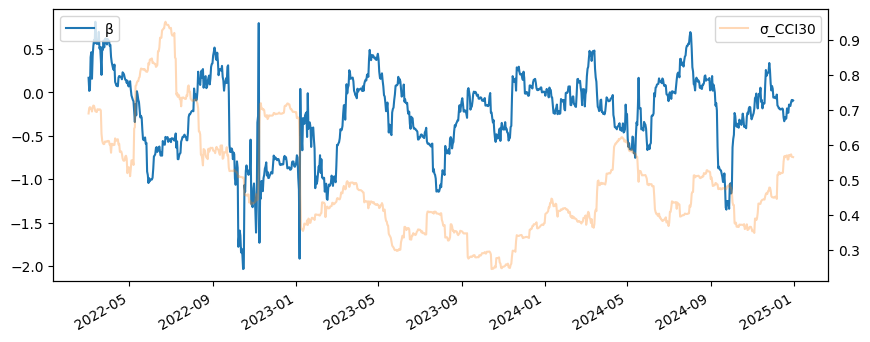

In [844]:
vol = combined_ret['cci30_ret'].rolling(60).std() * np.sqrt(252)
fig, ax = plt.subplots(figsize=(10,4))
ax2 = ax.twinx()
roll_beta.plot(ax=ax, label='β', color='C0')
vol.plot(ax=ax2, label='σ_CCI30', color='C1', alpha=0.3)
ax.legend(loc='upper left'); ax2.legend(loc='upper right')


### Residualized of rolling mkt return

Residual Annualized Sharpe: 1.49


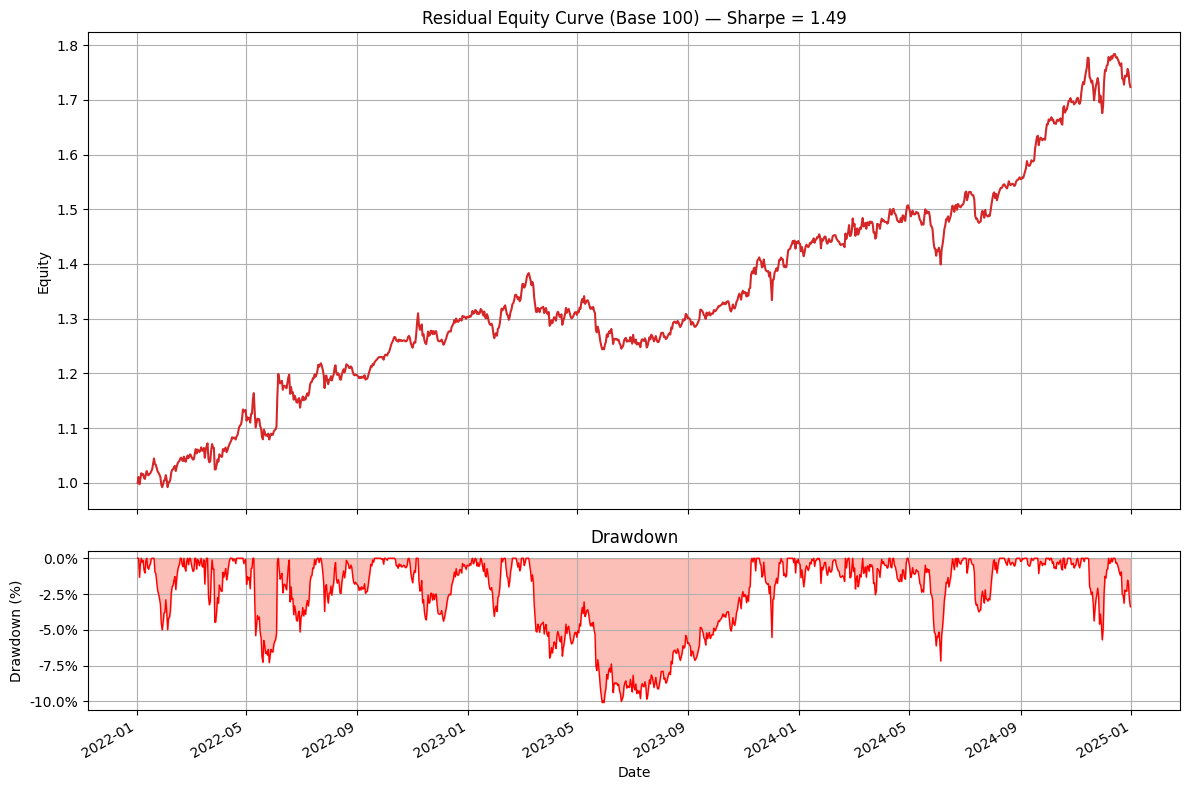

In [845]:
# 2) Static beta of your strategy to CCI30
crypto_strategy_cov = combined_ret['strat_ret'] \
						 .cov(combined_ret['cci30_ret'])
crypto_variance    = combined_ret['cci30_ret'] \
						 .var()
crypto_beta        = crypto_strategy_cov / crypto_variance

# 3) Strip out that beta from your P&L
residual_returns = combined_ret['strat_ret'] \
					 - crypto_beta * combined_ret['cci30_ret']

# 4) Build a base-100 residual equity curve
residual_equity = 1 + residual_returns.cumsum()


# 1) Compute annualized Sharpe of residual returns (no risk-free)
daily_sr = residual_returns.mean() / residual_returns.std()
ann_sr   = daily_sr * np.sqrt(365)
print(f"Residual Annualized Sharpe: {ann_sr:.2f}")

# 2) Compute drawdown series (percent)
running_max = residual_equity.cummax()
drawdown    = residual_equity / running_max - 1

# 3) Plot equity + drawdown in stacked subplots
fig, (ax_eq, ax_dd) = plt.subplots(
	nrows=2, ncols=1,
	sharex=True,
	figsize=(12, 8),
	gridspec_kw={'height_ratios': [3, 1]}
)

# Equity curve
ax_eq.plot(residual_equity.index, residual_equity, color='C3')
ax_eq.set_title(f"Residual Equity Curve (Base 100) — Sharpe = {ann_sr:.2f}")
ax_eq.set_ylabel("Equity")
ax_eq.grid(True)

# Drawdown
ax_dd.fill_between(drawdown.index, drawdown, 0, color='salmon', alpha=0.5)
ax_dd.plot(drawdown.index, drawdown, color='red', lw=1)
ax_dd.set_title("Drawdown")
ax_dd.set_ylabel("Drawdown (%)")
ax_dd.set_xlabel("Date")
ax_dd.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.1f}%"))
ax_dd.grid(True)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Signal Stability

### IC over time

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_946/2907676387.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key='timestamp', freq='M'))
/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_946/2907676387.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[signal].corr(g[ret_col], min_periods=2))


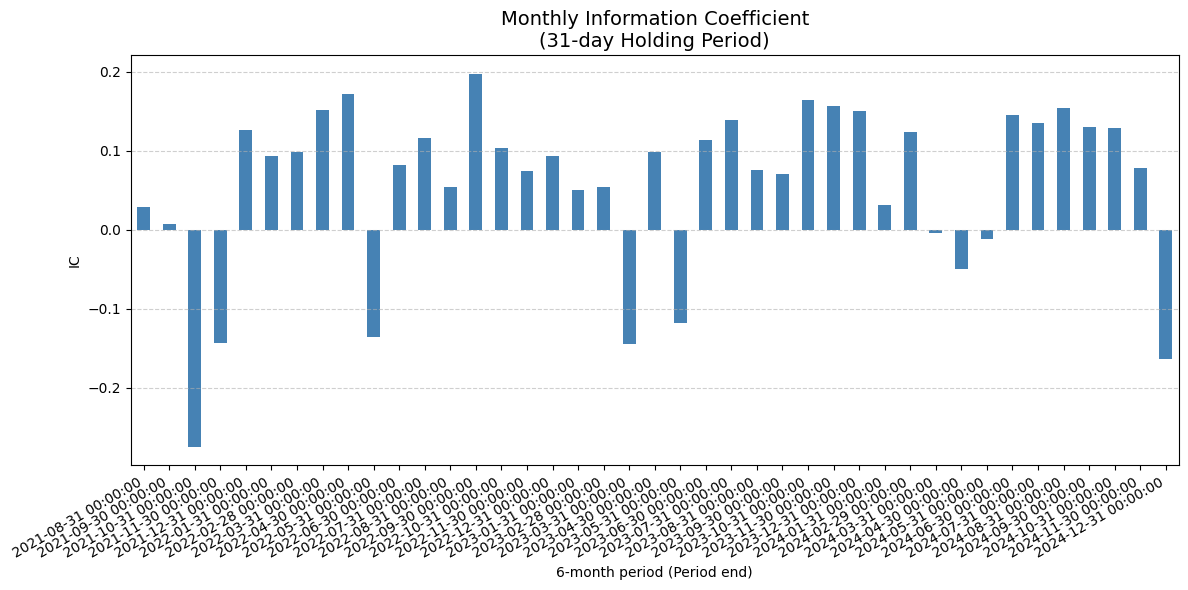

In [846]:
import pandas as pd
import matplotlib.pyplot as plt

# ── CONFIG ────────────────────────────────────────────────────────────────
signal = 'signal'          # column with your alpha weights
h      = int(avg_holding_period)                 # holding-period horizon to analyse (days)
							 # → set to 1, 5, 20 … whatever you like

ret_col = f'fwd_combined_return_{h}d_demeaned'

df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

ic_1m = (
		df_filtered
			.groupby(pd.Grouper(key='timestamp', freq='M'))
			.apply(lambda g: g[signal].corr(g[ret_col], min_periods=2))
			.dropna()
)

# ── 3) Plot --------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
ic_1m.plot(kind='bar', ax=ax, color='steelblue')

ax.set_title(f'Monthly Information Coefficient\n({h}-day Holding Period)', fontsize=14)
ax.set_xlabel('6-month period (Period end)')
ax.set_ylabel('IC')
fig.autofmt_xdate() 
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### ic over time variant 2

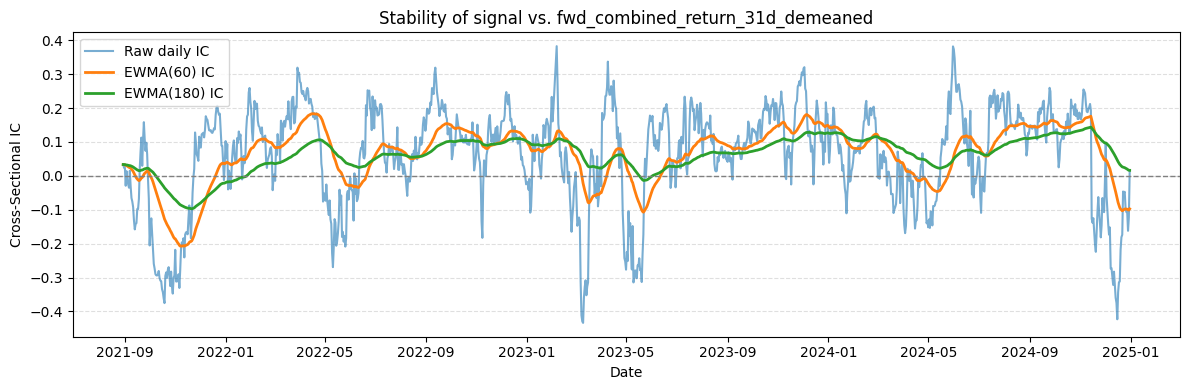

In [847]:
import pandas as pd
import matplotlib.pyplot as plt

# your parameters
signal_col = 'signal'
ret_col    = f'fwd_combined_return_{h}d_demeaned'

# 1) filter out any missing signal or return
df2 = df_filtered.dropna(subset=[signal_col, ret_col])
df2 = df2[df2.timestamp>'2021-01-01']

# 2) compute raw daily IC (min 2 obs per day)
daily_ic = (
		df2
			.groupby('timestamp')[[signal_col, ret_col]]
			.apply(lambda g: g.iloc[:,0].corr(g.iloc[:,1], min_periods=2))
			.dropna()
)

# 3) smooth it with a 60‐day EWMA
ewma_ic = daily_ic.ewm(span=60, adjust=False).mean()
ewma_ic_2 = daily_ic.ewm(span=180, adjust=False).mean()

# 4) plot
plt.figure(figsize=(12,4))
plt.plot(daily_ic.index, daily_ic,  label='Raw daily IC', alpha=0.6)
plt.plot(ewma_ic.index,   ewma_ic,    label='EWMA(60) IC',    linewidth=2)
plt.plot(ewma_ic_2.index,   ewma_ic_2,    label='EWMA(180) IC',    linewidth=2)
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.title(f'Stability of signal vs. {ret_col}')
plt.xlabel('Date')
plt.ylabel('Cross-Sectional IC')
plt.legend()
fig.autofmt_xdate() 
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
